# From the collective dipole moment to the dielectric relaxation spectrum

## Auto correlation function

We start with the collective dipole moment
It is separate for each species (i.e. IM1H, OAC, ...)

In [9]:
import numpy as np
from newanalysis.correl import correlateParallel
from matplotlib import pyplot as plt
from scipy.signal import correlate

In [2]:
residues = ["IM1H", "OAC", "IM1", "HOAC"]
md = {}
md["all"] = np.loadtxt("data/md_all.txt")
for residue in residues:
    md[residue] = np.loadtxt(f"data/md_{residue}.txt")
dt = 1 #ps
n = 5000 #frames
time_axis = np.arange(0, n*dt, dt)


In [3]:
np.ascontiguousarray(md["all"].T)

array([[ -1.00320728, -19.900516  ,  -3.88271606, ...,  19.8578116 ,
         11.88007554,  22.52508984],
       [-21.82201517, -18.23343125, -14.70222407, ..., -19.90064985,
        -25.86013744, -12.28660636],
       [  9.82434817,  -0.79922288,   9.19884293, ...,   8.24453618,
         22.09435147,  23.15757497]])

Make the autocorrelation function
we can do it for the total dipole moment, or for the individual ones

In [10]:
def correlate(data1, data2, **kwargs):
    data1 = np.ascontiguousarray(data1.T)
    data2 = np.ascontiguousarray(data2.T)
    data1 = data1-data1.mean()
    data2 = data2-data2.mean()
    out = np.zeros(len(data1.T))
    for i in len(data1):

    

In [4]:
md_all = np.ascontiguousarray(md["all"].T)
md0mdt = np.zeros(n)
correlateParallel(md_all, md_all, md0mdt, ltc=1)


In [31]:
md0mdt[0]

719.2082755773258

In [40]:
(md_all[0]-md_all[0].mean()*md_all[0]-md_all[0].mean())

-7.275957614183426e-16

In [28]:
md_scipy = np.sum(md["all"], axis=1)
print(md_scipy.shape)
md0mdt_scipy = correlate(md_scipy-md_scipy.mean(), md_scipy-md_scipy.mean(), mode="valid")

(5000,)


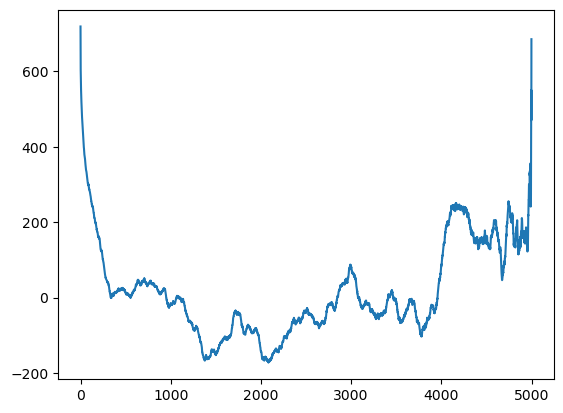

In [30]:
plt.plot(time_axis,md0mdt)
#plt.plot(md0mdt_scipy)